This is our entry for the competition DVCon25 India - a UNet for Self Driving Cars. The task of the competition was to propose a novel edge AI application, and then build an custom accelerator for it. The designed accelerator can be found at [this GitHub repository](https://github.com/yasith46/self_driving_unet_custom_ip).

This code was inspired by [Ritwek Khosla's notebook](https://www.kaggle.com/code/vanvalkenberg/image-segmentation-u-net-for-self-driving-cars)

In [3]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [4]:
# Check the version of each library
print("OS version:", os.name)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("OpenCV version:", cv2.__version__)
print("TensorFlow version:", tf.__version__)

OS version: posix
Numpy version: 1.26.4
Pandas version: 2.2.3
OpenCV version: 4.11.0
TensorFlow version: 2.18.0


### Custom classes in order to classify the pixels into:
The original dataset has 16 classes. We reduce this to 16 by grouping some redundant classes together, which would have little use of differentiating for an self driving system.

In [5]:
REVERSE_CLASS = {
    # Living being
    0 : (64, 128, 64),  
    1 : (0, 128, 192),   
    2 : (64, 0, 128), 
    3 : (192, 64, 128),
    4 : (128, 64, 64),
    5 : (128, 64, 128),
    6 : (128, 128, 192),
    7 : (128, 0, 192),
    8 : (192, 0, 64),
    9 : (128, 128, 128),
    10: (64, 0, 64),   # Wall
    11: (0, 128, 64),   # Bridge
    12: (128, 128, 0),      # Tree
    13: (64, 192, 128),     # ParkingBlock
    14: (192, 192, 128),    # Column/Pole
    15: (192, 128, 128),    # Sign/Symbol
    16: (0, 0, 0)
}

In [6]:
CUSTOM_CLASSES = {
    # Living being
    (64, 128, 64):  0,     # Animal
    (64, 64, 0):    0,     # Pedestrian
    (192, 128, 64): 0,     # Child
    (64, 0, 192):   0,     # Cart/Luggage/Pram
    
    # Bike
    (0, 128, 192): 1,      # Bicyclist
    (192, 0, 192): 1,      # Motorcycle/Scooter
    
    # Vehicle
    (64, 0, 128):    2,    # Car
    (64, 128, 192):  2,    # SUV / Pickup
    (192, 128, 192): 2,    # Truck / Bus
    (192, 64, 128):  2,    # Train

    # Misc
    (128, 64, 64):   3,    # OtherMoving

    # Road
    (128, 64, 128):  4,    # Drivable Surface

    # Shoulder
    (128, 128, 192): 5,

    # Lane Markings Drivable
    (128, 0, 192):   6,

    # Non-drivable
    (192, 0, 64):    7,    # LaneMkgsNonDriv

    # Sky
    (128, 128, 128): 8,

    # Tunnel + Archway
    (64, 0, 64):     9,    # Tunnel
    (192, 0, 128):   9,    # Archway

    # Building/Wall/Bridge
    (128, 0, 0):     10,   # Building
    (64, 192, 0):    10,   # Wall
    (0, 128, 64):    10,   # Bridge

    # Vegetation area
    (128, 128, 0):   11,   # Tree
    (192, 192, 0):   11,   # VegetationMiscA

    (64, 192, 128):  12,   # ParkingBlock

    (192, 192, 128): 13,   # Column/Pole
    (0, 0, 64):      13,   # Cone
    (64, 64, 128):   13,   # Fence
    (0, 0, 192):     13,   # Sidewalk
    
    (192, 128, 128): 14,   # Traffic Light
    (0, 64, 64):     14,   # Sign / symbol
    (128, 128, 64):  15,   # Misc Text

    # Other
    (0, 0, 0):       15,   # Void
}

NUM_CLASSES = len(set(CUSTOM_CLASSES.values()))

In [7]:
# Converts mask RGB to class IDs
def convert_mask_to_custom_class(mask, mapping, shape=256):
    mask = cv2.resize(mask, (shape, shape))
    
    if mask.ndim == 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    elif mask.shape[2] == 4:
        mask = mask[:, :, :3]

    if mask.dtype != np.uint8:
        mask = (mask * 255).astype(np.uint8)

    class_mask = np.zeros(mask.shape[:2], dtype=np.uint8)

    for rgb, class_id in mapping.items():
        rgb = np.array(rgb, dtype=np.uint8)
        match = np.all(mask == rgb, axis=-1)
        class_mask[match] = class_id

    return class_mask

In [8]:
# Convert class ID mask to RGB using REVERSE_CLASS
def convert_class_id_to_rgb(class_mask, color_map):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    
    for class_id, color in color_map.items():
        rgb_mask[class_mask == class_id] = color
    
    return rgb_mask

### Loading Data
Here we use the data from CamVid - Cambridge Driving Labelled Database found [here](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/). The database has screencaptures from a recording of a dashcam.

In [9]:
# Data loading function
def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=256):
    imgNames = os.listdir(imgPath)
    maskNames = [re.sub('\.png', '_L.png', mem) for mem in imgNames]
    
    for i in range(len(imgNames)):
        img = plt.imread(os.path.join(imgPath, imgNames[i]))
        mask = plt.imread(os.path.join(maskPath, maskNames[i]))
        
        img = cv2.resize(img, (shape, shape))
        mask = convert_mask_to_custom_class(mask, CUSTOM_CLASSES, shape)
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [10]:
# Load data
framObjTrain = {'img': [], 'mask': []}
framObjValidation = {'img': [], 'mask': []}
framObjTrain = LoadData(framObjTrain, imgPath='/kaggle/input/camvid/CamVid/train', maskPath='/kaggle/input/camvid/CamVid/train_labels', shape=128)
framObjValidation = LoadData(framObjValidation, imgPath='/kaggle/input/camvid/CamVid/val', maskPath='/kaggle/input/camvid/CamVid/val_labels', shape=128)

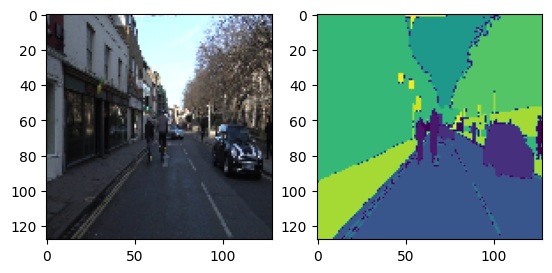

In [11]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

### Model

In [18]:
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 8, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(len(REVERSE_CLASS), (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputImage], outputs=[output])
    return model

## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
myUNet = GiveMeUnet(inputs, droupouts= 0.07)
myUNet.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

In [20]:
## trainign our model
X_train = np.array(framObjTrain['img'])
y_train = np.array(framObjTrain['mask'])

history = myUNet.fit(X_train, y_train, epochs=200, verbose=1)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 991ms/step - accuracy: 0.8264 - loss: 0.6721
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8305 - loss: 0.6529
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 982ms/step - accuracy: 0.8293 - loss: 0.6502
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 980ms/step - accuracy: 0.8320 - loss: 0.6351
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8361 - loss: 0.6183
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 980ms/step - accuracy: 0.8404 - loss: 0.6002
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8351 - loss: 0.6121
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 983ms/step - accuracy: 0.8402 - loss: 0.5909
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 999ms/step - accuracy: 0.8407 - loss: 0.5861
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8409 - loss: 0.5837
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8396 - loss: 0.5831   
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 21

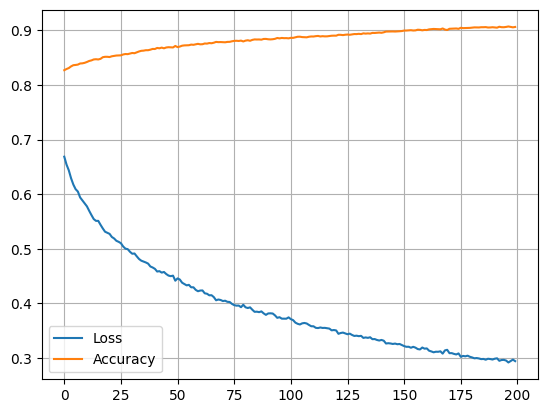

In [21]:
# Plot training curve
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.grid(True)

### Validation

In [26]:
def Plot16Trios(images, preds, masks):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(8, 6, figsize=(48, 48))  # 8 rows, 6 cols (2 trios per row)
    fig.subplots_adjust(wspace=0.05, hspace=0.2)

    for i in range(16):
        row = i // 2
        col_offset = (i % 2) * 3

        # Original
        axes[row, col_offset].imshow(images[i])
        axes[row, col_offset].set_title("Image", fontsize=8)
        axes[row, col_offset].axis('off')

        # Prediction
        axes[row, col_offset + 1].imshow(preds[i])
        axes[row, col_offset + 1].set_title("Pred", fontsize=8)
        axes[row, col_offset + 1].axis('off')

        # Ground Truth
        axes[row, col_offset + 2].imshow(convert_class_id_to_rgb(masks[i], REVERSE_CLASS))
        axes[row, col_offset + 2].set_title("GT", fontsize=8)
        axes[row, col_offset + 2].axis('off')

    plt.tight_layout()
    plt.show()


In [27]:
def predict16_random(valMap, model):
    indices = np.random.choice(len(valMap['img']), size=16, replace=False)
    
    img = np.array(valMap['img'])[indices]
    mask = np.array(valMap['mask'])[indices]
    
    pred_probs = model.predict(img)
    pred_ids = np.argmax(pred_probs, axis=-1)
    pred_rgbs = [convert_class_id_to_rgb(p, REVERSE_CLASS) for p in pred_ids]
    
    return pred_rgbs, img, mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


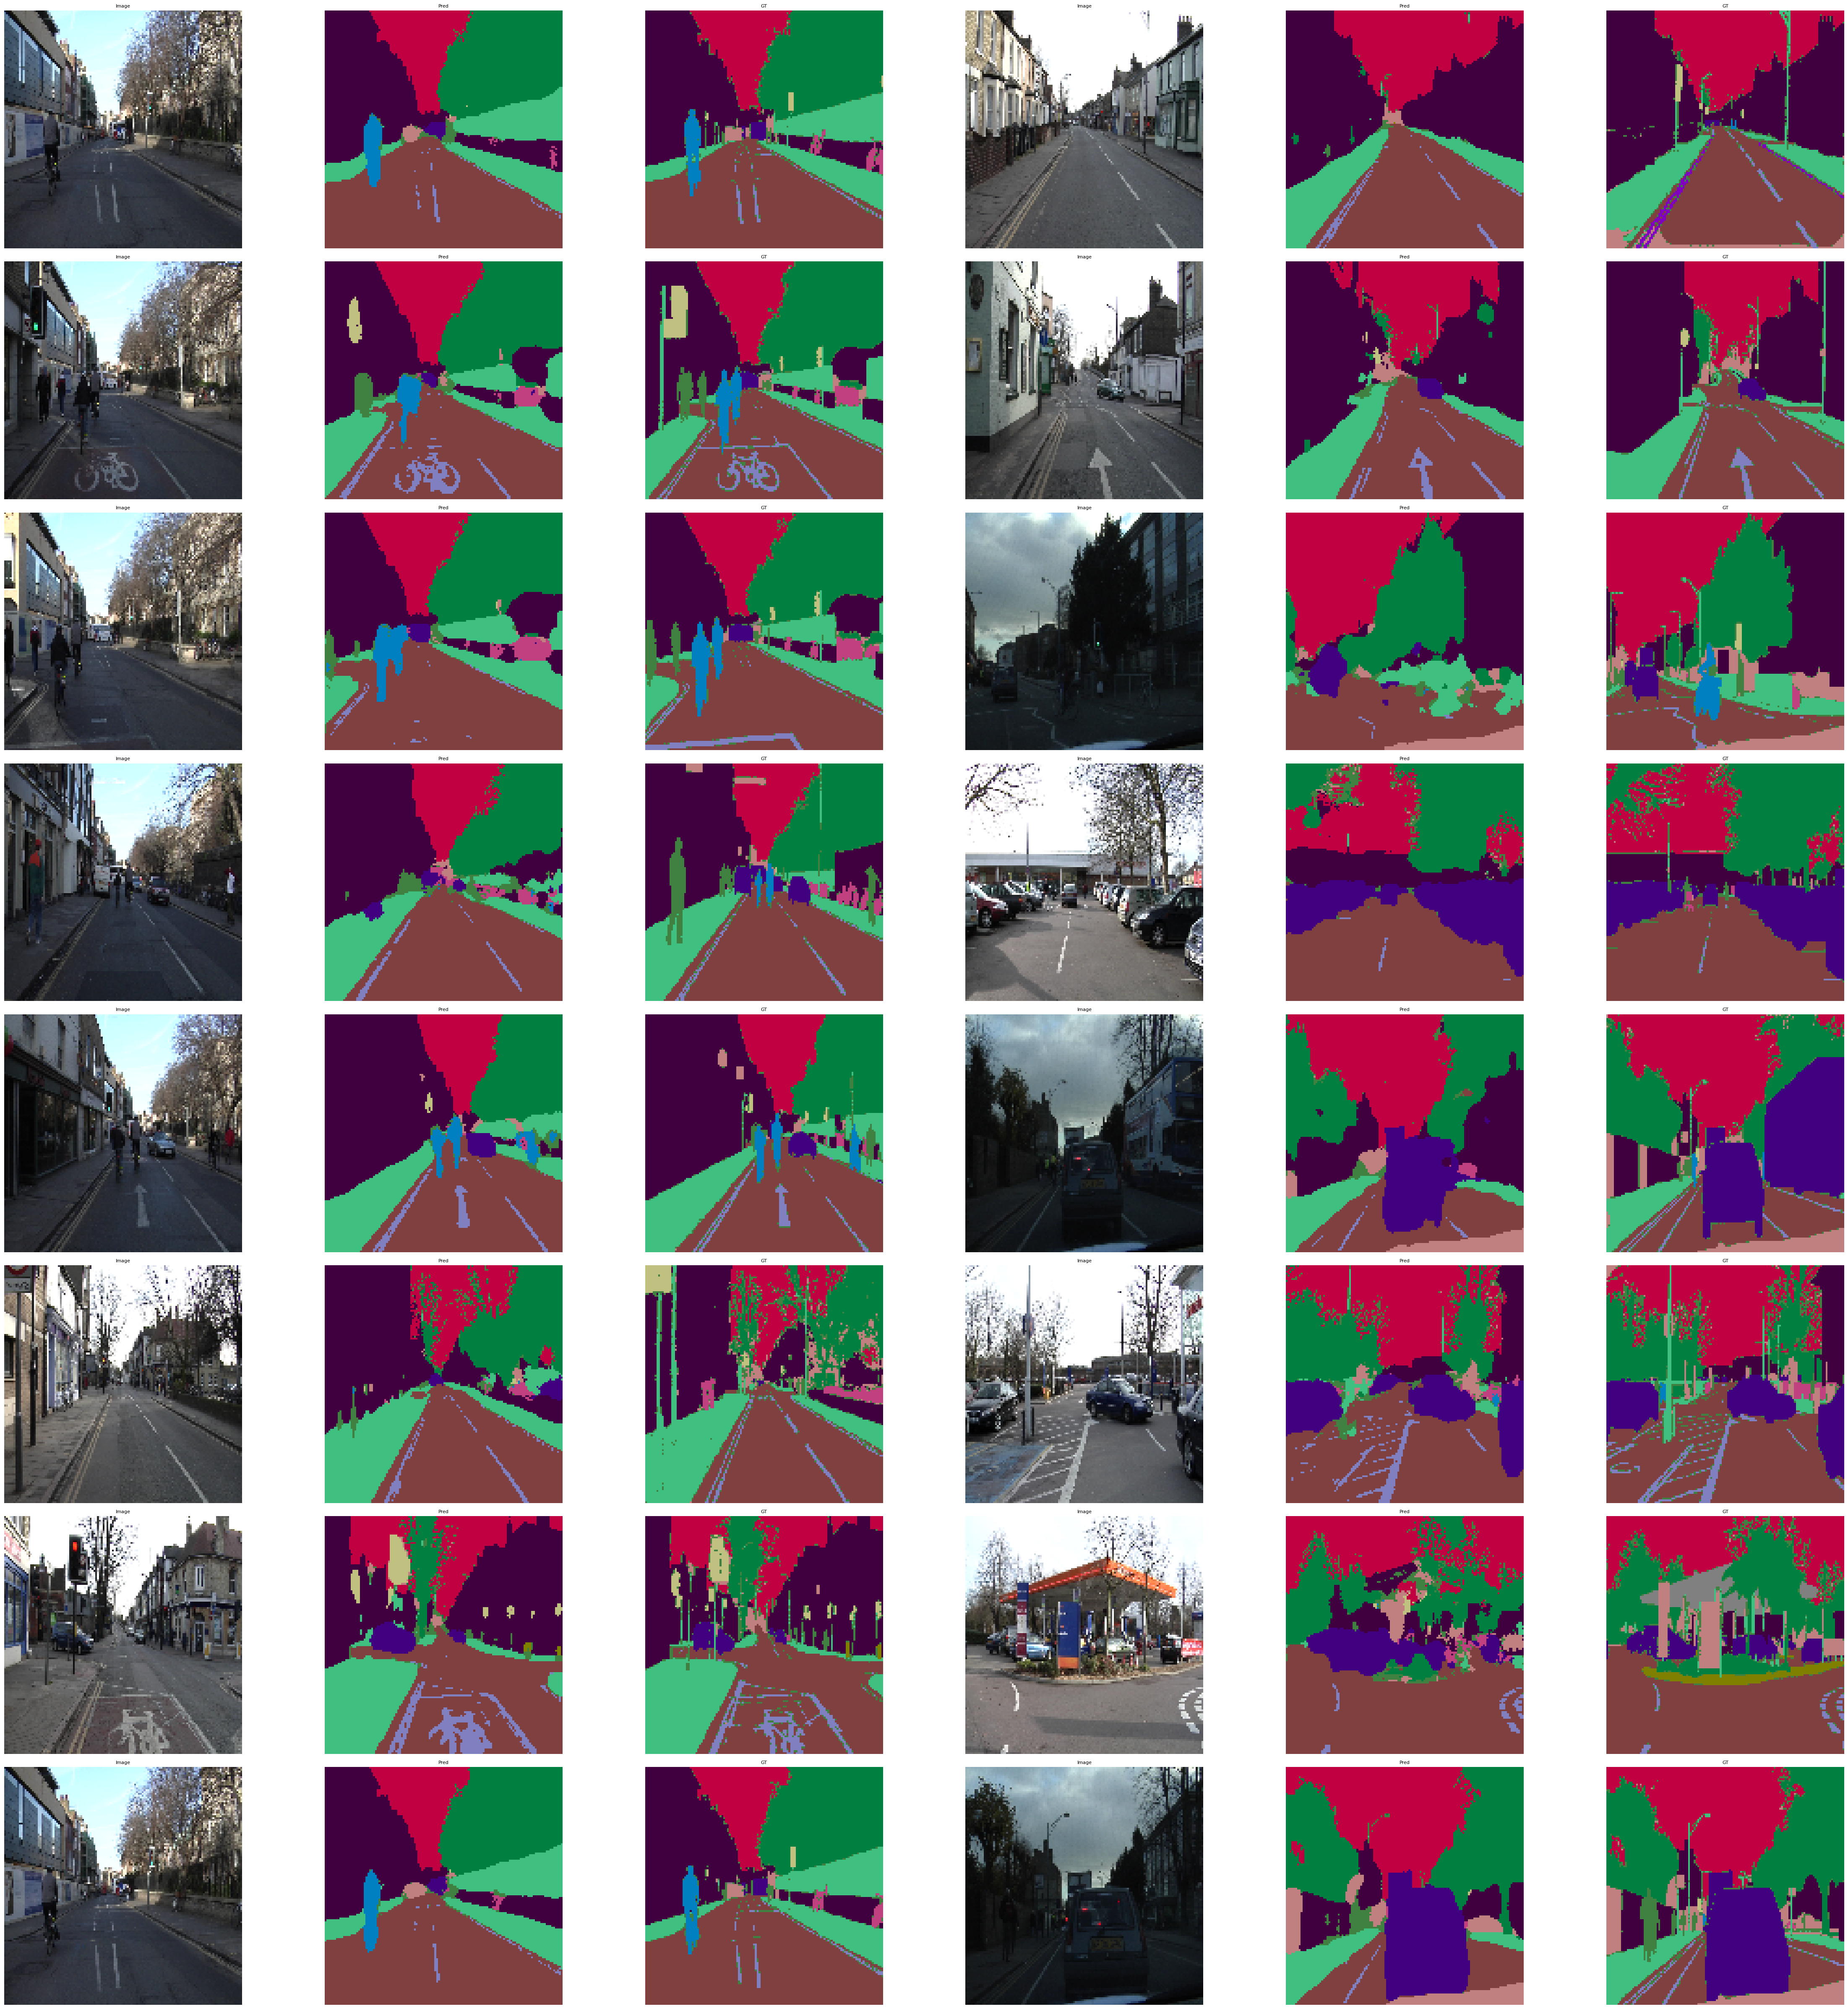

In [31]:
preds, images, masks = predict16_random(framObjValidation, myUNet)
Plot16Trios(images, preds, masks)

In [32]:
# Convert validation data to numpy arrays
X_val = np.array(framObjValidation['img'])
y_val = np.array(framObjValidation['mask'])

# Evaluate the model on the validation data
val_loss, val_accuracy = myUNet.evaluate(X_val, y_val, verbose=1)

# Print the results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.8598 - loss: 0.5215
Validation Loss: 0.5406
Validation Accuracy: 0.8558


### Saving the model

In [53]:
myUNet.export("my_unet_model")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_147']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


Saved artifact at 'my_unet_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_147')
Output Type:
  TensorSpec(shape=(None, 128, 128, 17), dtype=tf.float32, name=None)
Captures:
  137607820545104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820543568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820545872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820545488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820543760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820544912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820545680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820547984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820548752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137607820547024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

In [54]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        yield [tf.cast(input_value, tf.float32)]  # Yield a batch of one image

In [56]:
converter = tf.lite.TFLiteConverter.from_saved_model("my_unet_model")

# Enable optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set representative dataset for calibration
converter.representative_dataset = representative_data_gen

# Force full integer quantization for input, output, and weights
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8     # or tf.int8 depending on your input preprocessing
converter.inference_output_type = tf.uint8    # or tf.int8

# Convert the model
tflite_quant_model = converter.convert()

# Save the quantized model
with open("my_unet_model_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)

W0000 00:00:1749279649.354892      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749279649.354936      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8
